In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [152]:
jobids = []
params = []
data = []
N = 19
folder_xx = datapath/"xx"
folder_zz = datapath/"zz"
files_xx = ["7347408_N19_RS.jld2","7347409_N19_RS.jld2"]
for (i,file) in enumerate(files_xx):
    with h5py.File(folder_xx/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)

In [154]:
T = 10 ** np.linspace(-3,1,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)

In [98]:
res_xx = data[0][:,:,0,0]
res_xx_nn = data[1][:,:,0,0]
red_xx = np.zeros((res_xx.shape[0],N//2+1))
red_xx_nn = np.zeros((res_xx.shape[0],N//2+1))

for j in range(0,N//2):
    red_xx[:,j] = 0.5*(res_xx[:,j]+res_xx[:,N-j-1])
    red_xx_nn[:,j] = 0.5*(res_xx_nn[:,j]+res_xx_nn[:,N-j-1])
red_xx[:,N//2] = res_xx[:,N//2]
red_xx_nn[:,N//2] = res_xx_nn[:,N//2]

In [145]:
def model(x,a,b):
    return a*x**b

In [170]:
red_xx.shape

(100, 10)

In [188]:
popt = []
perr = []
tfitmax = [35,35,25,25,25,25,25,15]
tfitmin = [0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,8):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_xx[tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [223]:
for j in range(0,8):
    print(popt[j][0]*(9-j)**12)

84.45991172748792
80.81778636177727
83.12270052088189
80.56392348024458
81.47445321414985
84.00041106917259
107.26875452065548
142.26806564358196


In [317]:
popt_nn = []
perr_nn = []
tfitmax_nn = [65,65,60,60,55,55,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0]
for j in range(0,8):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_xx_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_nn.append(poptj_nn)
    perr_nn.append(np.sqrt(np.diag(pcovj_nn)))

In [328]:
for j in range(0,8):
    print(popt_nn[j][0])

0.1413073561157257
0.7037356835904871
6.218298612477575
19.323677380072308
83.90046688892014
123.89178302075211
237.99393116951376
106.46503358796049


In [332]:
tcut = np.zeros(8)
for j in range(0,8):
    tcut[j] = (popt[j][0]/popt_nn[j][0])**(1/(popt_nn[j][1]-popt[j][1]))
    print(tcut[j])

0.26906346824121363
0.21461092012297642
0.16734827553280093
0.12337780043732105
0.08398187213591235
0.05313875335029451
0.026433664237588132
0.01309425093054745


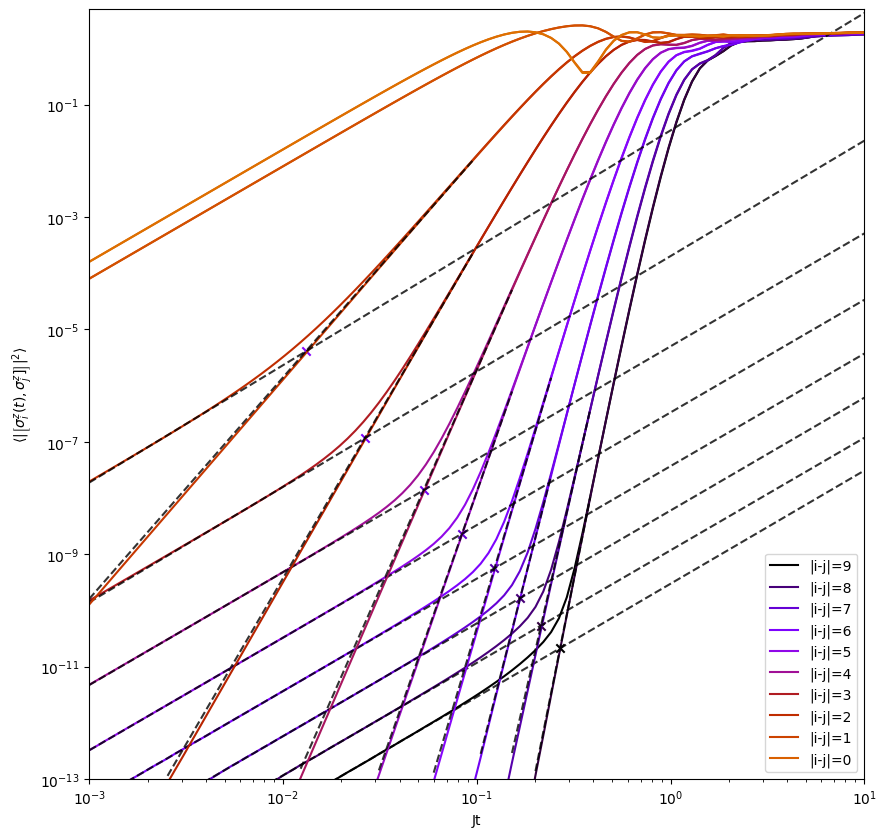

In [334]:
NUM_COLORS = N+1
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red_xx[:,j],label="|i-j|={}".format(N//2+1-j-1))
    ax.plot(T,red_xx_nn[:,j])
    if j <= 7:
        ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
        ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
        ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x")
ax.legend(loc="lower right")
ax.set_xlabel("Jt")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_xlim(1e-3,10)
ax.set_ylim(1e-13,5)
plt.show()

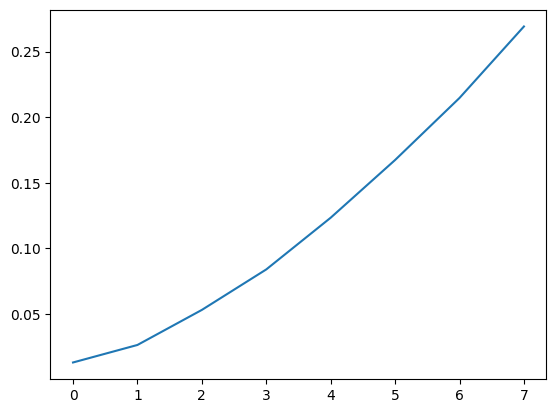

In [340]:
plt.plot(x[0:8],np.flip(tcut))

In [209]:
T[70]

0.6734150657750828

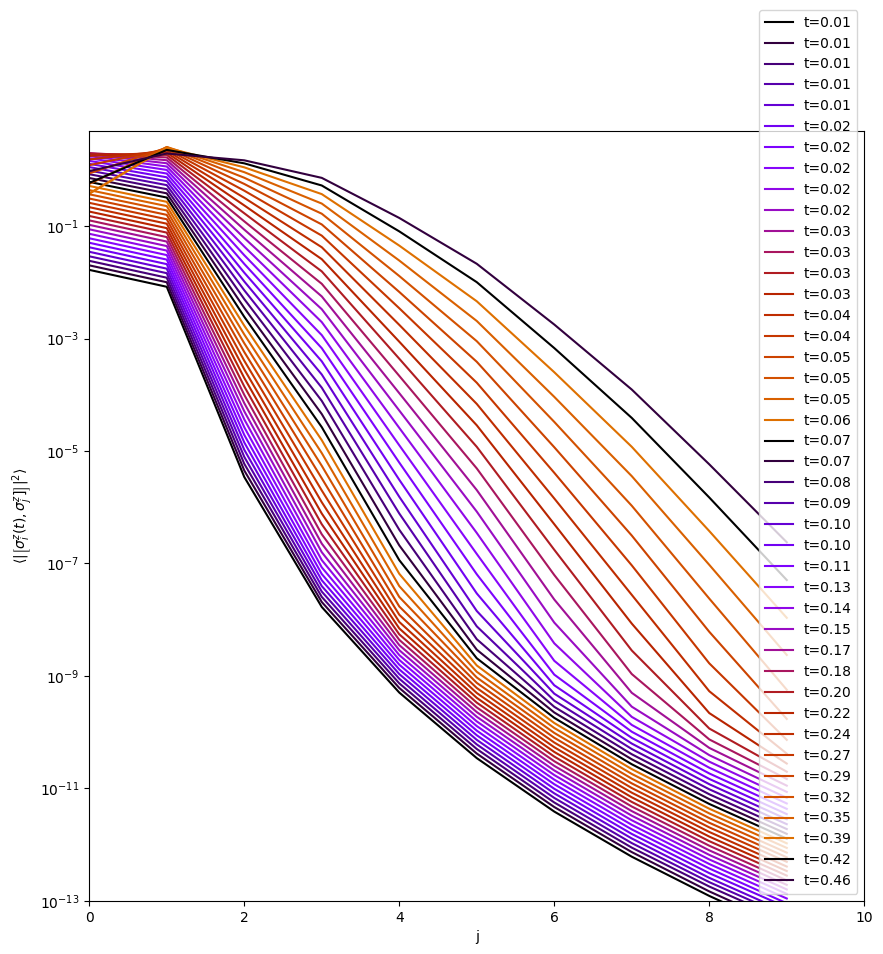

In [141]:
NUM_COLORS = N+1
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for ti,t in enumerate(T):
    if t >= 0.01 and t<= 0.5:
        ax.semilogy(range(0,N//2+1),np.flip(red_xx[ti,:]),label="t={:.2f}".format(t))
ax.legend(loc="lower right")
ax.set_xlabel("j")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_ylim(1e-13,5)
ax.set_xlim(0,N//2+1)
plt.show()